In [1]:
# what are the steps taht we perform here

# [x] grab the data 
# [] run multiple gauss fits over the date with multiple initialization points 
# [] check what is the result for each run and which one gives the least error
# [] take only 70% of the points 
# [] write the result to the csv

# [] final consolidated table -> made per channel per type of gene

In [17]:
# want to see the images inline
%matplotlib inline

# imports
# general 
import os
import glob
from functools import reduce
import re
import csv as csv
# scientific 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, datasets
from scipy.stats import norm, gamma
from scipy.optimize import curve_fit
from scipy import special

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# simple gamma function
def g_x(x, a, c):
    return x**(a - 1)*np.exp(-x)/special.gamma(a) + c

In [4]:
# function for loading one data-set
def load_data(file_path, skiprows_=1):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
    else:
        I = data[:, -1]
    return I

In [5]:
# some folder magic 
# folder = '/Volumes/1TB/2018-05-15-12-30-27-SEA12-full-stack/' # folder contains z-corrected spots 
folder = '/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/'

In [6]:
# some const params for all graphs
num_bins = 100; 
# graph [xmin, xmax]
xmin = -0.2
xmax = 1.2

binwidth = (xmax - xmin)/(num_bins - 1)

In [9]:
bins = np.arange(xmin, xmax + binwidth, binwidth)
print ('bins: ', bins.shape)

bins:  (100,)


I_min: 0.04 I_max: 1.14
6.060148998854757 0.03415496012968451 0.052672809208123506
peak center: 0.30030030030030025


(-0.2, 1.2)

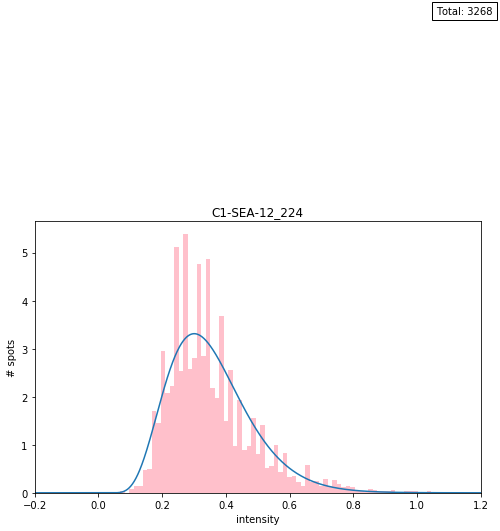

In [13]:
# for testing 
filename = 'C1-SEA-12_227'
filepath =  folder + "csv/" + filename + '.csv'
I = load_data(filepath)

fig = plt.figure(figsize=(8,5))
title = "C1-SEA-12_224"
plt.title(title)
    
plt.xlabel('intensity')
plt.ylabel('# spots')

print("I_min:", min(I), "I_max:", max(I))

I_res = I
fit_alpha, fit_loc, fit_beta = gamma.fit(I_res)
print(fit_alpha, fit_loc, fit_beta)

plt.hist(I, bins=bins, color='pink', density=True); # 
# plt.text(0.9*xmax, 0.1, "Total: " + str(I.shape[0]), color='black', bbox=dict(facecolor='white', alpha=1))

info_text = "Total: " + str(I.shape[0])

x_limits = [xmin, xmax]
ymax = np.max(np.histogram(I, bins)[0])
y_limits = [0, ymax]

plt.text(x_limits[1] - (x_limits[1] - x_limits[0])*0.1, y_limits[0] + (y_limits[1] - y_limits[0])*0.04, info_text, color='black', bbox=dict(facecolor='white', alpha=1))
   

x = np.linspace(xmin, xmax, 1000)
y = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
plt.plot(x,y)

print("peak center:", x[np.argmax(y)])

plt.xlim([xmin, xmax])

# plt.legend(loc = 'upper right')

In [14]:
# possible labels 
stain = ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
stage = 'E' # only embryos
comment = '' # only empty ones

In [15]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'

In [19]:
# read the db and parse images that we want to process
df = pd.read_csv(folder + "smFISH-database/SEA-12-Table 1.csv", sep=',', na_values=['']);
df.head()

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,SEA-12,NaN,670.0,FISH,DPY-23_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,NaN,2017-05-28_SEA12_dpy23_wdr52_mdh1_006 series042,SEA-12_277,-1,NaN,NaN,NaN,NaN,NaN
1,SEA-12,NaN,670.0,FISH,DPY-23_EX,405.0,NUCLEAR,NaN,488.0,AF,...,oversaturated,NaN,2017-04-04_SEA12_DPY23_028 series001,SEA-12_144,-1,NaN,NaN,NaN,NaN,NaN
2,SEA-12,NaN,670.0,FISH,DPY-23_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,NaN,2017-05-24_SEA12_dpy23_wdr52_mdh1_001 series005,SEA-12_298,-1,NaN,NaN,NaN,NaN,NaN
3,SEA-12,NaN,670.0,FISH,DPY-23_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,NaN,2017-05-23_SEA12_DPY23_wdr52_mdh-1_002 series009,SEA-12_299,-1,NaN,NaN,NaN,NaN,NaN
4,SEA-12,NaN,670.0,FISH,DPY-23_EX,610.0,FISH,MDH-1,570.0,FISH,...,NaN,NaN,2017-05-23_SEA12_DPY23_wdr52_mdh-1_002 series014,SEA-12_300,-1,NaN,NaN,NaN,NaN,NaN


In [20]:
# this is general
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())
good_indices.shape[0]


print(np.sum(good_indices == True))

62


In [23]:
# choose necessary stains
dataset1 = []
df_good = (df[type_columns].astype(np.object) == stain[0]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].values[row]
dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [24]:
# choose necessary stains
dataset2 = []
df_good = (df[type_columns].astype(np.object) == stain[1]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].values[row]
dataset2 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [25]:
# choose necessary stains
dataset3 = []
df_good = (df[type_columns].astype(np.object) == stain[2]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].values[row]
dataset3 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [26]:
print(len(dataset1) + len(dataset2) + len(dataset3))

144


In [27]:
def create_title(path, name_id=8):
    # get the name of the initial image
    image_name = path.split("/")[name_id] # was 8
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4]
    return title
# create_title("/Users/kkolyva/Desktop/n2/N2-results/all/C1-N2_9.csv")

In [37]:
labels = ['MDH-1'] # ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
color = '#BA5536'
if labels[0] == 'MDH-1':
    color = "#693D3D"

In [38]:
# actual plotting 
dataset_to_use = dataset1
if labels[0] == 'MDH-1':
    dataset_to_use = dataset3
    
dataset = []
p_dataset = []
for j in range(0, len(dataset_to_use)):
    tmp = folder + "csv/" + dataset_to_use[j] + ".csv"
    dataset.append(tmp)
    print(tmp)

/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_277.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_274.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_211.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_213.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_209.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_239.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_231.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_255.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_227.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_259.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_292.csv
/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/procecssing/csv/C2-SEA-12_

In [39]:
# how good is fitter-meter?
def fitter_meter(y, y_hat):
    return [mean_absolute_error(y,y_hat), np.sqrt(mean_squared_error(y,y_hat))]

In [40]:
center_path = folder  + "centers/" + "all-centers.csv"  

error: L1, L2 [3.3573259895507173, 7.185026757117936]
peak center: 0.4929292929292933


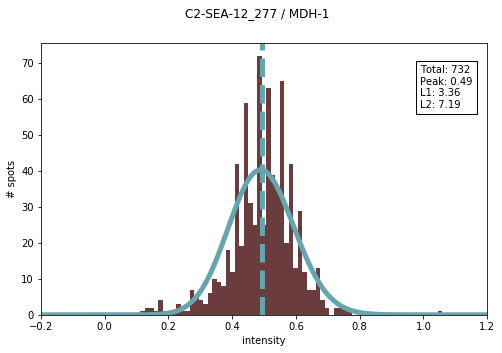

error: L1, L2 [3.287277056818498, 5.666217520018093]
peak center: 0.46464646464646503


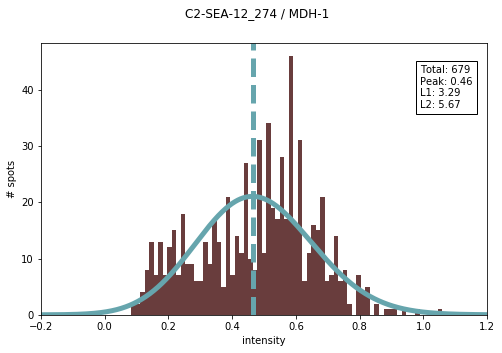

error: L1, L2 [1.69427576239098, 3.3757129394574164]
peak center: 0.6343434343434349


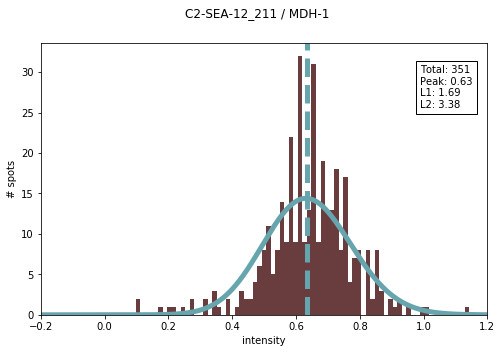

error: L1, L2 [2.5336280657502037, 4.515625121988124]
peak center: 0.5353535353535357


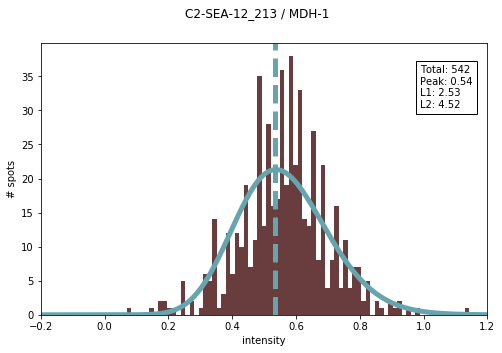

error: L1, L2 [1.1541421072335034, 2.448240657392167]
peak center: 0.47878787878787915


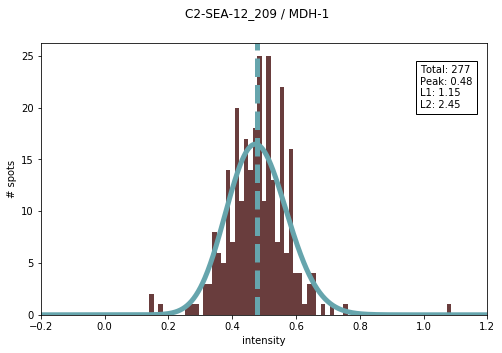

error: L1, L2 [2.146249611871779, 3.7073720877492584]
peak center: 0.6060606060606064


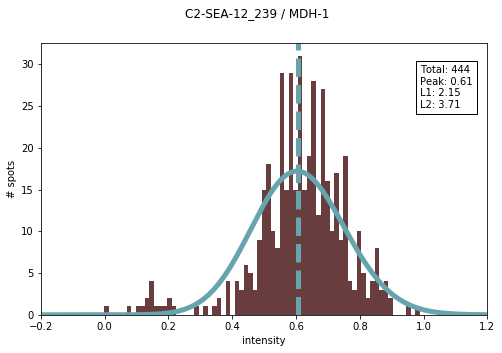

error: L1, L2 [2.8896525125878862, 7.518927752663753]
peak center: 0.4363636363636367


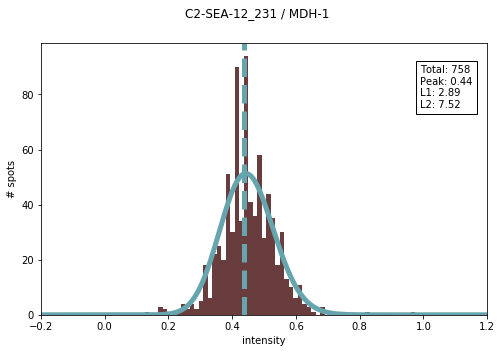

error: L1, L2 [3.5649236051526776, 7.100359550940015]
peak center: 0.35151515151515184


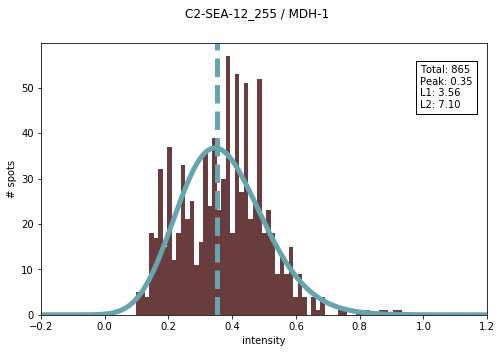

error: L1, L2 [2.7325497926823084, 6.484845470514034]
peak center: 0.46464646464646503


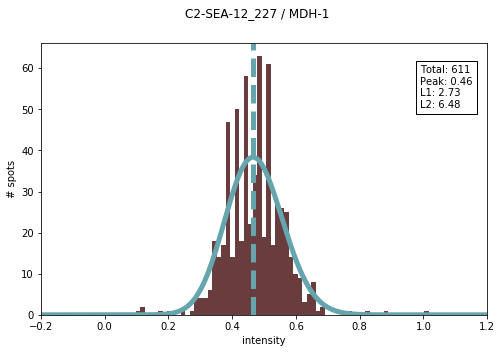

error: L1, L2 [2.223440125142974, 4.765388823151454]
peak center: 0.4505050505050509


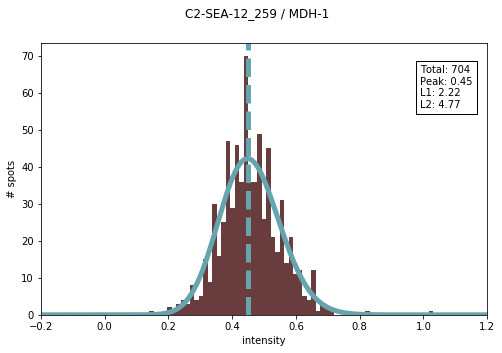

error: L1, L2 [2.967994525820991, 5.874637044283823]
peak center: 0.5353535353535357


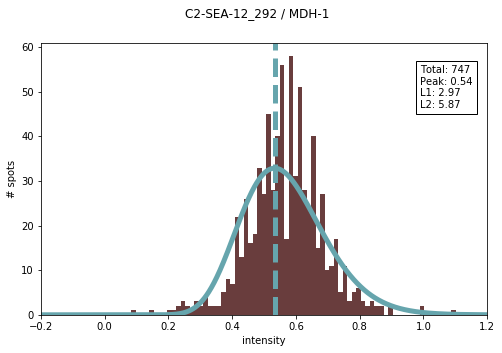

error: L1, L2 [1.5556301651760671, 2.992775409640528]
peak center: 0.47878787878787915


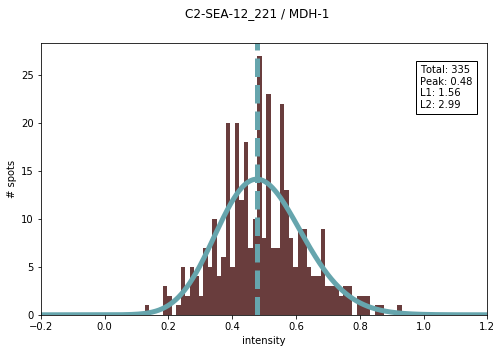

error: L1, L2 [3.4501305788825043, 6.858842599885523]
peak center: 0.5353535353535357


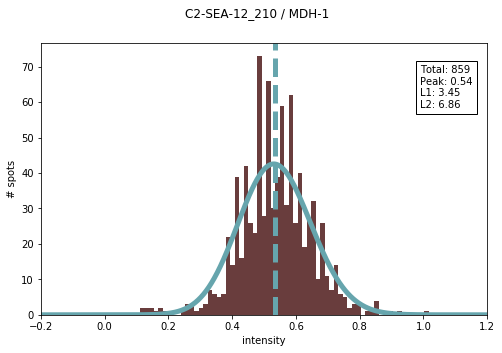

error: L1, L2 [1.697311556749271, 3.8808357480453557]
peak center: 0.5070707070707074


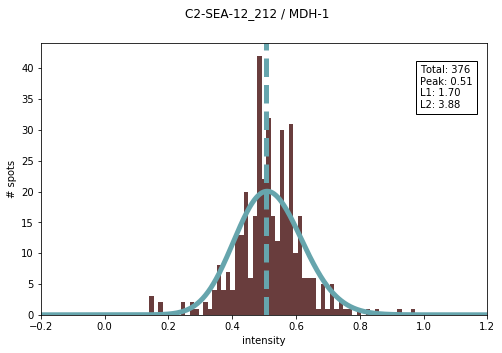

error: L1, L2 [2.7649532770698473, 5.6527917412099375]
peak center: 0.47878787878787915


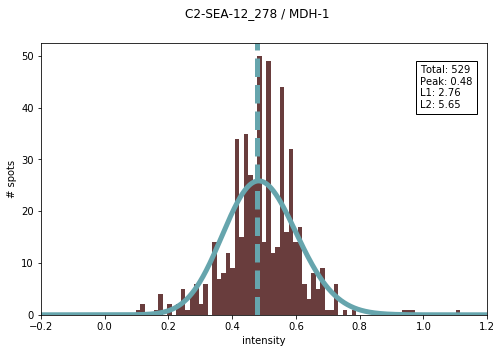

error: L1, L2 [1.4427100636885055, 2.793417837464462]
peak center: 0.5353535353535357


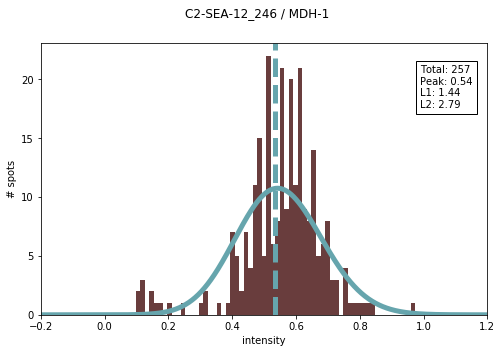

error: L1, L2 [2.3567497979613, 4.623998120729967]
peak center: 0.5070707070707074


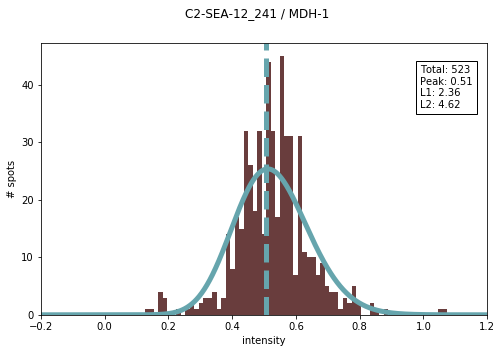

error: L1, L2 [2.093851568184574, 4.381654272680081]
peak center: 0.5636363636363642


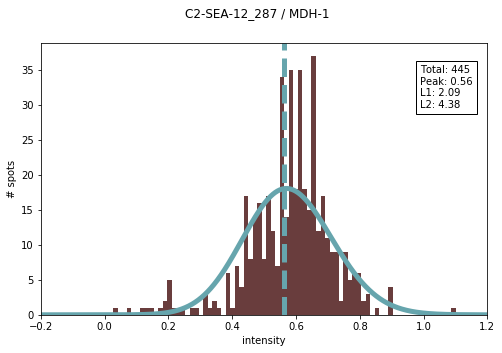

error: L1, L2 [2.7909786368183265, 5.904265621725649]
peak center: 0.47878787878787915


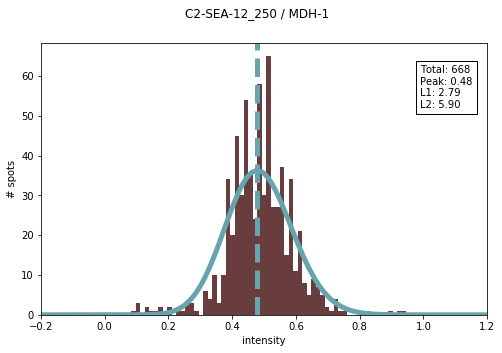

error: L1, L2 [2.221266622851548, 5.299775378542185]
peak center: 0.42222222222222255


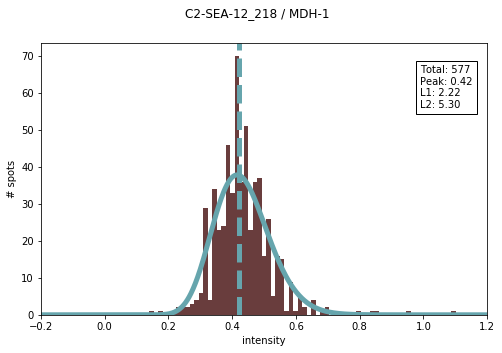

error: L1, L2 [2.0885324094034146, 3.3826852725464422]
peak center: 0.5777777777777782


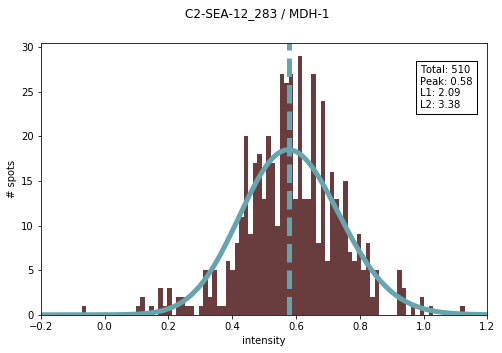

error: L1, L2 [2.811230567692191, 4.934351422532588]
peak center: 0.5494949494949499


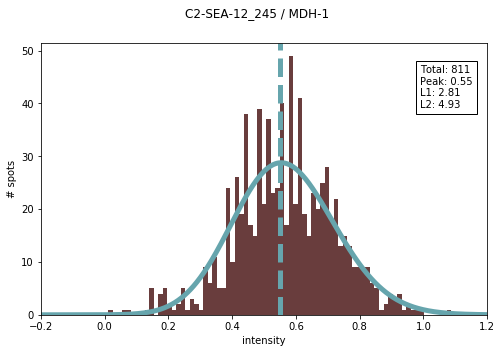

error: L1, L2 [3.01620676959338, 4.999586736289296]
peak center: 0.6343434343434349


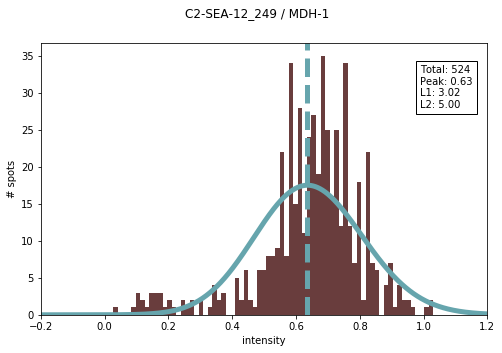

error: L1, L2 [1.6376714822607938, 3.255360467326148]
peak center: 0.6626262626262631


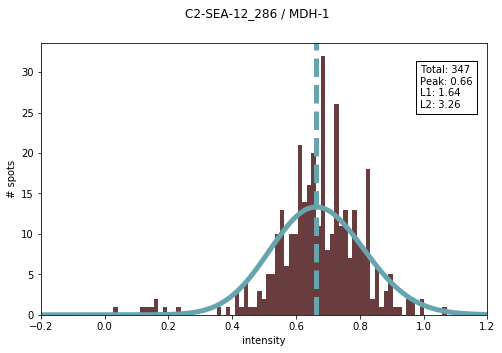

error: L1, L2 [1.880522653662172, 3.277501094727304]
peak center: 0.5919191919191924


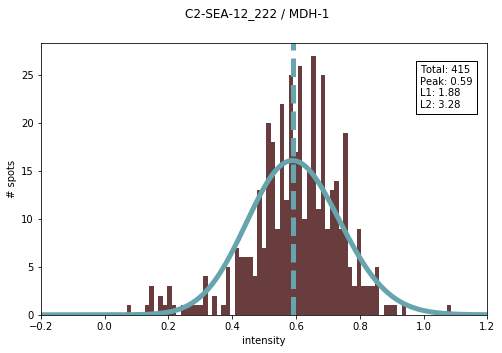

error: L1, L2 [2.4356128381977524, 5.60804415494181]
peak center: 0.4363636363636367


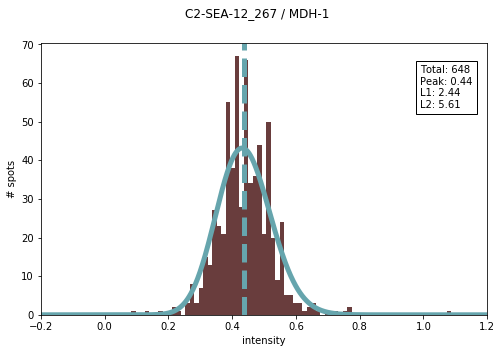

error: L1, L2 [3.953878874220311, 9.310519449048456]
peak center: 0.5212121212121217


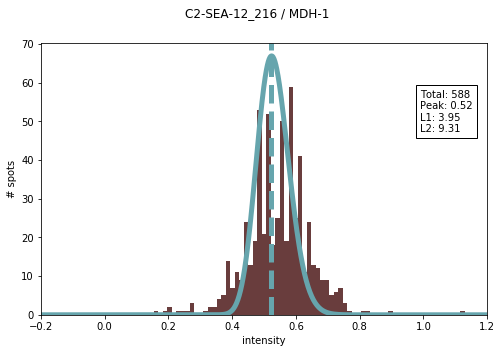

error: L1, L2 [1.650199467354794, 2.909546584018588]
peak center: 0.6626262626262631


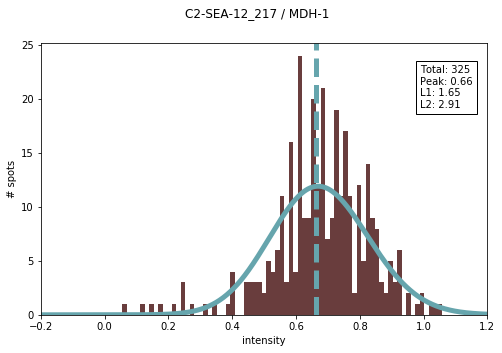

error: L1, L2 [1.782673825847111, 3.9356899716197282]
peak center: 0.5353535353535357


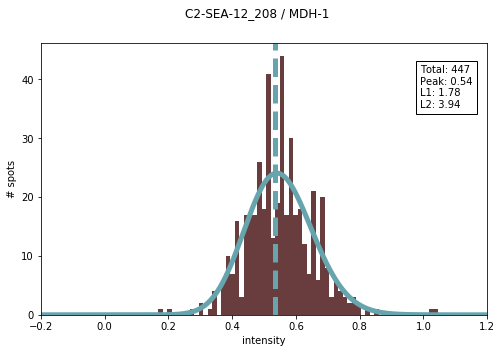

error: L1, L2 [1.9861850315700778, 4.465843257714074]
peak center: 0.46464646464646503


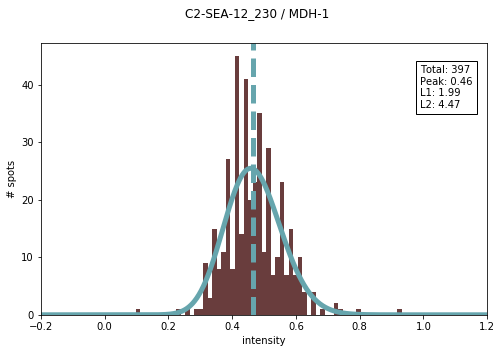

error: L1, L2 [2.2187326250927053, 4.298587197769511]
peak center: 0.5777777777777782


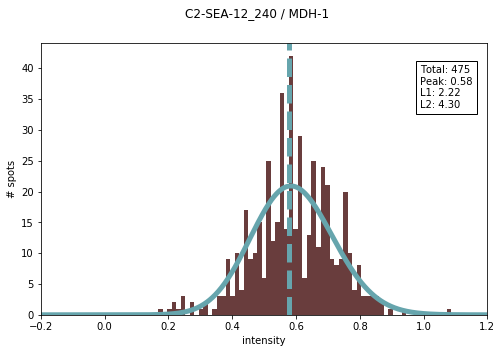

error: L1, L2 [2.7068596388950463, 5.664833299107963]
peak center: 0.47878787878787915


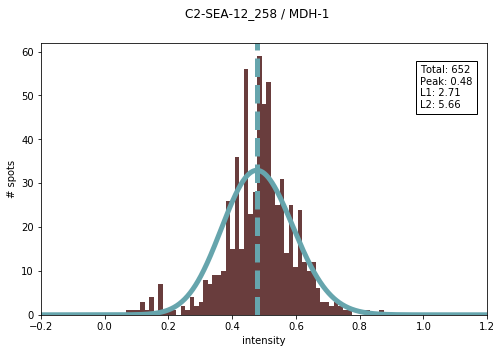

error: L1, L2 [2.8393179361420806, 5.029245328849743]
peak center: 0.5070707070707074


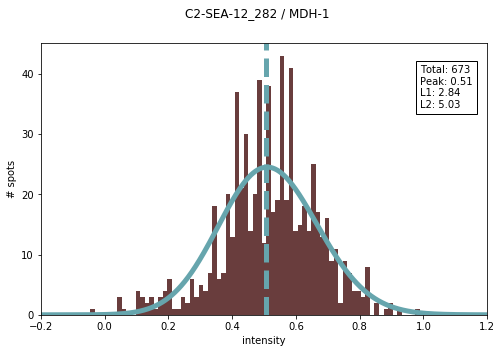

In [41]:
# have to perform this step multiple times and choose the best one 
# perform n_fits with different initial parameters
# n_fits = 10

center_set = {}

# actual plotting 
for idx in range(0, len(dataset)):    
    if(not os.path.exists(dataset[idx])):
        # print("doesn't exist")
        continue
        
    try:
        # create the canvas
        fig = plt.figure(figsize=(8,5))
        title = create_title(dataset[idx], name_id=6)
        fig.suptitle(title + " / " + labels[0])

        # load the data and scale it accordingly
        I = load_data(dataset[idx], skiprows_=0)

        I_res = I
        # calculate the params for gauss fit
        binned_values, real_bins = np.histogram(I, bins)
        use_median = np.median(I_res)
        # inititally there was use_median/2 
        fit_alpha, fit_loc, fit_beta = gamma.fit(I_res, loc=use_median/2, scale=1/np.max(binned_values))
        # normalization factor
        factor = np.sum(binned_values*np.diff(real_bins))

        plt.hist(I, bins=bins, color=color, label=labels, density=False)

        x = np.linspace(xmin, xmax, 1000)
        y = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)*factor
        plt.plot(x,y, linewidth=5, color='#66A5AD')
        yhat = gamma.pdf(real_bins, fit_alpha, fit_loc, fit_beta)*factor

        # vertical line for center
        plt.axvline(x=real_bins[np.argmax(yhat)], linestyle="--", linewidth=5, color='#66A5AD')

        if (np.any(np.isnan(yhat))):
            continue

        error = fitter_meter(binned_values, yhat[:-1])

        print("error: L1, L2", error)
        print("peak center:", real_bins[np.argmax(yhat)])

        # reasonable adjustments to make the data look nicer
        plt.xlabel('intensity')
        plt.ylabel('# spots')

        info_text = "Total: " + str(I.shape[0]) + "\n" + "Peak: " +  str('%.2f' % real_bins[np.argmax(yhat)]) + "\n" + "L1: " + str('%.2f' % error[0]) + "\n" + "L2: " +  str('%.2f' % error[1]) 

        x_limits = [xmin, xmax]
        ymax = np.max(np.histogram(I, bins)[0])
        y_limits = [0, ymax]

        plt.text(x_limits[1] - (x_limits[1] - x_limits[0])*0.15, y_limits[1]*0.8, info_text, color='black', bbox=dict(facecolor='white', alpha=1))
        plt.xlim([xmin, xmax])

        # save the peak values for further 
        center_set[title] = real_bins[np.argmax(yhat)]  
        folder_path = folder + "histograms/" + labels[0] + "/"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        plt.savefig(folder_path + title + ".pdf") 
        plt.show()
        # break
    except(RuntimeError, TypeError, ValueError):
        print("There was an exception but we\'ll fix it for you")
df_center = pd.DataFrame(list(center_set.items()), columns=['filename', 'center'])
if (os.path.exists(center_path)):
    df_center.to_csv(center_path, index=False, header=False, encoding='utf-8', mode = 'a')
else:
    df_center.to_csv(center_path, index=False, header=True, encoding='utf-8', mode = 'w' )
    print (df_center)

### ?plt.hist